In [2]:
import numpy as np
import torch
import os
import pickle
import time
from Model import *
from itertools import chain
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.utils.data import DataLoader
from synthetic import simulate_lorenz_96, simulate_var
from utils import build_flags, time_split, save_result, evaluate_result, count_accuracy, loss_sparsity, loss_divergence, loss_mmd

In [1]:
def choseGPU():
    '''在程序运行最开始, 根据GPU使用情况，自动选择GPU'''
    from re import findall
    from subprocess import check_output
    from torch.cuda import set_device, is_available
    
    if(is_available()):
        output = check_output("nvidia-smi", shell=True)
        info = findall("(\d+)MiB\s/\s(\d+)MiB", output.decode("utf-8"))
        print("--> 开始查询GPU使用情况：")
        # 正确匹配
        best_index = 0
        current_um = -1
        for index, (um, am) in enumerate(info):
            print("第{:^3}块显卡：已使用{:^8}Mib, 全部{:^8}Mib，使用率:{:^8.2%}".format(index, um, am, float(um)/float(am)))
            best_index = index if(current_um>float(um) and current_um>=0) else best_index
            current_um = float(um)
        # 选择
        best_index=best_index
        print("--> 选择第{:^3}块GPU".format(best_index))
        set_device(best_index)
        
    else:
        print("显卡不可用")
        
# 设置随机数种子
# set_random_seed()
# 选择GPU
choseGPU()

--> 开始查询GPU使用情况：
第 0 块显卡：已使用 20349  Mib, 全部 24564  Mib，使用率: 82.84% 
第 1 块显卡：已使用 20351  Mib, 全部 24564  Mib，使用率: 82.85% 
--> 选择第 0 块GPU


In [23]:
parser = build_flags()
args = parser.parse_args(args=[])
args.seed = 2
args.num_nodes = 264
args.dims = 1
args.threshold = 0.5
args.time_length = 500
args.time_step = 10
args.epochs = 3000
args.batch_size = 64
args.lr = 1e-3
args.weight_decay = 1e-3
args.encoder_alpha = 0.02
args.decoder_alpha = 0.02
args.beta_sparsity = 0.05 #0.25   #log_sum  #1.25是F=40,N=30的最优值
args.beta_kl = 0.01        #JS散度
args.beta_mmd = 2      #MMD
args.encoder_hidden = 20
args.decoder_hidden = 20
args.encoder_dropout = 0.1
args.decoder_dropout = 0.2

In [4]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

In [36]:
samples = np.load('/home/omnisky/Public/ChenRongfa/Intrer_VAE/PNC_SPM_emoid1.npy')
X_np = []
# for sample in samples[0,:,:]:
    # X_np.append(np.array(time_split(sample[:,:,np.newaxis], step=10)))
sample = samples[0,:,:]
# sample = sample[:,:,np.newaxis]
X_np.append(np.array(time_split(sample[:,:,np.newaxis], step=10)))
X_np = np.vstack(X_np)
X_np = torch.FloatTensor(X_np)
# X_np = torch.FloatTensor(sample)

In [37]:
print(X_np.shape)

torch.Size([201, 264, 10, 1])


In [7]:
data = X_np
data_loader = DataLoader(data, batch_size=args.batch_size)

In [ ]:
adj = []
for idx in range(264):
    decoder_file = 'decoder' + str(idx) + '.pt'
    decoder_file = os.path.join('/home/omnisky/Public/ChenRongfa/Intrer_VAE_result/DLCR_PNC_emoid1', decoder_file)
    decoder_net = decoder(args.dims, args.decoder_hidden, args.time_step - 1, args.num_nodes, args.decoder_dropout, args.decoder_alpha)
    decoder_net.load_state_dict(torch.load(decoder_file, map_location='cuda:0'))
    adj.append(decoder_net.adj[idx, :])

In [ ]:
init_adj = torch.cat([temp.unsqueeze(0) for temp in adj], dim=0)
init_adj = init_adj.clone().detach()
print(init_adj.shape)

In [ ]:
for idx in range(200, 230):
    print('Begin training feature: {:04d}'.format(idx + 1))
    decoder_file = 'decoder' + str(idx) + '.pt'
    decoder_file = os.path.join('/home/omnisky/Public/ChenRongfa/Intrer_VAE_result/PNC_emoid1', decoder_file)
    Inter_decoder = decoder(args.dims, args.decoder_hidden, args.time_step - 1, args.num_nodes, args.decoder_dropout, args.decoder_alpha)
    Inter_decoder = Inter_decoder.cuda()
    optimizer = optim.Adam(params = Inter_decoder.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    loss_val = nn.MSELoss()
    best_loss = np.Inf
    for epoch in range(200):
        scheduler.step()
        t = time.time()
        Loss = []
        mse_loss = []
        for batch_idx, data in enumerate(data_loader):
            data = data.cuda()
            target = data[:, idx, 1:, :]
            optimizer.zero_grad()
            inputs = data[:, :, :-1, :]
            pred = Inter_decoder(inputs, idx)
            mse = loss_val(pred, target)
            loss = mse

            loss.backward()
            optimizer.step()


            Loss.append(loss.item())
            mse_loss.append(mse.item())

        if epoch % 100 == 0:
            print('Feature: {:04d}'.format(idx + 1),
                'Epoch: {:04d}'.format(epoch),
                'Loss: {:.10f}'.format(np.mean(Loss)),
                'MSE_Loss: {:.10f}'.format(np.mean(mse_loss)),
                'time: {:.4f}s'.format(time.time() - t))

            
        if np.mean(mse_loss) < best_loss:
            best_loss = np.mean(mse_loss)
            torch.save(Inter_decoder.state_dict(), decoder_file)
            # print('Feature: {:04d}'.format(idx + 1),
            #       'Epoch: {:04d}'.format(epoch),
            #       'Loss: {:.10f}'.format(np.mean(Loss)),
            #       'mse_loss: {:.10f}'.format(np.mean(mse_loss)),
            #       'mmd_loss: {:.10f}'.format(np.mean(mmd_loss)),
            #       'time: {:.4f}s'.format(time.time() - t), file=log)

In [38]:
init_adj = np.load('/home/omnisky/Public/ChenRongfa/Intrer_VAE/init_adj.npy')
init_adj = torch.tensor(init_adj)

In [39]:
causality_matrix = []
total_gamma_matrix = []
total_theta_matrix = []
#init_adj = torch.eye(20)
for idx in range(1):
    # encoder_file = 'encoder' + str(idx) + '.pt'
    # encoder_file = os.path.join('/home/omnisky/Public/ChenRongfa/fmri_sim4', encoder_file)
    encoder_file = '/home/omnisky/Public/ChenRongfa/encoder1.pt'
    est_net = encoder(init_adj, args.dims, args.encoder_hidden, args.dims, args.time_step - 1, args.encoder_dropout, args.encoder_alpha)
    est_net.load_state_dict(torch.load(encoder_file))
    # est_net = est_net.to('cuda:1')
    est_net.eval()
    inputs = X_np[:, :, :-1, :]#.to('cuda:1')   #:-1和1:有什么区别
    mu, log_var = est_net(inputs)
    # mu = mu.cpu().detach()
    # log_var = log_var.cpu().detach()
    sigma = torch.exp(log_var / 2)
    # sigma2 = torch.exp(log_var2 / 2)
    gamma = torch.randn(size = mu.size())
    # theta = torch.randn(size = mu1.size())
    gamma = mu + sigma * gamma
    # theta = mu2 + sigma2* theta
    mask_matrix = torch.sigmoid(gamma) #* torch.sigmoid(theta)
    mask_matrix = mask_matrix.squeeze()
    causality_matrix.append(mask_matrix)
    # gamma_matrix = torch.sigmoid(gamma)
    # gamma_matrix = gamma_matrix.squeeze()
    # total_gamma_matrix.append(gamma_matrix)
    # theta_matrix = torch.sigmoid(theta)
    # theta_matrix = theta_matrix.squeeze()
    # total_theta_matrix.append(theta_matrix)

# np.save('/home/omnisky/Public/ChenRongfa/Intrer_VAE_result/result_fmri_concat/causality_matrix_10',causality_matrix)

causality_matrix = torch.stack(causality_matrix, dim=1)

# total_gamma_matrix = torch.stack(total_gamma_matrix, dim=1)
# total_theta_matrix = torch.stack(total_theta_matrix, dim=1)

In [45]:
print(causality_matrix.shape)

torch.Size([201, 1, 264, 9])


In [33]:
print(causality_matrix[0].shape)

torch.Size([201, 264, 9])


In [13]:
adj_gca = causality_matrix.mean(dim=3).mean(dim=0)
# np.save('/home/omnisky/Public/ChenRongfa/Intrer_VAE_result/result_fmri_concat/adj_gca_10',adj_gca.detach().numpy())
# gamma_adj = total_gamma_matrix.mean(dim=3).mean(dim=0)
# theta_adj = total_theta_matrix.mean(dim=3).mean(dim=0)
print(adj_gca.shape)

torch.Size([1, 264])


In [16]:
print(adj_gca.detach().numpy().shape)

(1, 264)


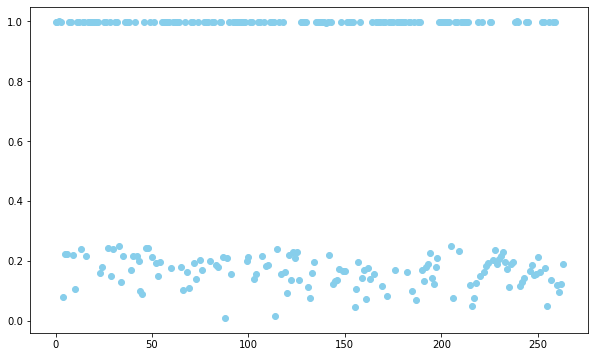

In [14]:
import matplotlib.pyplot as plt

# 示例数据
categories = np.arange(1,265).reshape(1, 264) # X轴的分类标签
# values = [23, 45, 56, 78]  # 每个分类对应的值

# 创建柱状图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.scatter(range(264),  adj_gca.detach().numpy().reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# 添加标题和标签
# plt.title('柱状图示例')  # 图形标题
# plt.xlabel('分类')  # X轴标签
# plt.ylabel('值')  # Y轴标签

# 显示图形
plt.show()


In [15]:
print(data.shape)

NameError: name 'data' is not defined

In [16]:
jisuan = adj_gca[adj_gca > 0.5]
print(len(jisuan))

130
